# Qrlew as a query Translator
[![View On GitHub](https://img.shields.io/badge/View_in_Github-grey?logo=github)](https://github.com/Qrlew/docs/blob/main/tutorials/mssql_translator.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Qrlew/pyqrlew/blob/main/examples/mssql_translator.ipynb)

In this notebook, we apply `qrlew` to translate SQL queries from one dialect e.g. PostgresSql to another such as MsSQL.

## Install and run the Microsoft SQL Server


In [1]:
%%capture
# Install the mssql-server 2017 (Not working on colab)
!curl https://packages.microsoft.com/keys/microsoft.asc | sudo tee /etc/apt/trusted.gpg.d/microsoft.asc
!curl https://packages.microsoft.com/config/ubuntu/$(lsb_release -rs)/prod.list | sudo tee /etc/apt/sources.list.d/mssql-release.list
!sudo apt-get update
!sudo ACCEPT_EULA=Y apt-get install -y msodbcsql18
!sudo ACCEPT_EULA=Y apt-get install -y mssql-tools18
!sudo apt-get install -y unixodbc-dev

# installing mssql-server
!curl -fsSL https://packages.microsoft.com/keys/microsoft.asc | sudo gpg --dearmor -o /usr/share/keyrings/microsoft-prod.gpg
!curl https://packages.microsoft.com/keys/microsoft.asc | sudo tee /etc/apt/trusted.gpg.d/microsoft.asc
!curl -fsSL https://packages.microsoft.com/config/ubuntu/22.04/mssql-server-2022.list | sudo tee /etc/apt/sources.list.d/mssql-server-2022.list
!sudo apt-get update
!sudo apt-get install -y mssql-server

# Configure and run the server manually. This is a workaround to install the MSSQL server in a colab
%env MSSQL_SA_PASSWORD="MyStrongPass$"
!sudo /opt/mssql/bin/mssql-conf -n setup accept-eula
!nohup /opt/mssql/bin/sqlservr &

In [2]:
# give time to the server to start and check that it started correctly
import time
time.sleep(10)
!/opt/mssql-tools18/bin/sqlcmd -S localhost -U SA -P $MSSQL_SA_PASSWORD -C -Q "SELECT 1"

           
-----------
          1

(1 rows affected)


In [3]:
%%capture
!pip install -U pyqrlew matplotlib graphviz sqlalchemy pyodbc

For the purpose of this demonstration, we focus on a single table.
We create the `census_schema` and `census_table` and we fill it with values.

In [4]:
sql_script = """
CREATE SCHEMA census_schema;
GO
CREATE TABLE census_schema.census_table (
    id INT IDENTITY(1,1)  PRIMARY KEY,
    first_name VARCHAR(50),
    last_name VARCHAR(50),
    age INT,
    gender VARCHAR(10),
    occupation VARCHAR(50),
    city VARCHAR(50),
    state VARCHAR(50)
);
GO
-- Inserting sample data
INSERT INTO census_schema.census_table (first_name, last_name, age, gender, occupation, city, state)
VALUES
    ('John', 'Doe', 30, 'Male', 'Engineer', 'New York', 'NY'),
    ('Jane', 'Doe', 28, 'Female', 'Engineer', 'Los Angeles', 'CA'),
    ('Bob', 'Smith', 45, 'Male', 'Analyst', 'Chicago', 'IL'),
    ('Alice', 'Johnson', 35, 'Female', 'Data Scientist', 'San Francisco', 'CA'),
    ('Tom', 'Brown', 50, 'Male', 'Lawyer', 'Miami', 'FL'),
    ('Emily', 'Davis', 32, 'Female', 'Software Developer', 'Seattle', 'WA'),
    ('Charlie', 'Miller', 40, 'Male', 'Accountant', 'Boston', 'MA'),
    ('Eva', 'Williams', 29, 'Female', 'Marketing Manager', 'Austin', 'TX'),
    ('Mike', 'Jones', 38, 'Male', 'Analyst', 'Denver', 'CO'),
    ('Sophia', 'Taylor', 42, 'Female', 'Analyst', 'Atlanta', 'GA'),
    ('John', 'Doe', 30, 'Male', 'Engineer', 'New York', 'NY'),
    ('Jane', 'Doe', 28, 'Female', 'Engineer', 'Los Angeles', 'CA'),
    ('Bob', 'Smith', 45, 'Male', 'Analyst', 'Chicago', 'IL'),
    ('Alice', 'Johnson', 35, 'Female', 'Data Scientist', 'San Francisco', 'CA'),
    ('Tom', 'Brown', 50, 'Male', 'Lawyer', 'Miami', 'FL'),
    ('Emily', 'Davis', 32, 'Female', 'Software Developer', 'Seattle', 'WA'),
    ('Charlie', 'Miller', 40, 'Male', 'Accountant', 'Boston', 'MA'),
    ('Eva', 'Williams', 29, 'Female', 'Marketing Manager', 'Austin', 'TX'),
    ('Mike', 'Jones', 38, 'Male', 'Analyst', 'Denver', 'CO'),
    ('Sophia', 'Taylor', 42, 'Female', 'Analyst', 'Atlanta', 'GA'),
    ('Alex', 'Johnson', 33, 'Male', 'Analyst', 'Portland', 'OR'),
    ('Megan', 'White', 27, 'Female', 'Data Scientist', 'San Diego', 'CA'),
    ('Daniel', 'Clark', 36, 'Male', 'Analyst', 'Houston', 'TX'),
    ('Olivia', 'Martinez', 31, 'Female', 'Data Scientist', 'Phoenix', 'AZ'),
    ('William', 'Lee', 48, 'Male', 'Professor', 'Philadelphia', 'PA'),
    ('Emma', 'Garcia', 29, 'Female', 'Data Scientist', 'Minneapolis', 'MN'),
    ('Ryan', 'Harris', 41, 'Male', 'Data Scientist', 'Dallas', 'TX'),
    ('Ava', 'Taylor', 26, 'Female', 'Product Manager', 'San Jose', 'CA'),
    ('Christopher', 'Anderson', 37, 'Male', 'Engineer', 'Detroit', 'MI'),
    ('Sophie', 'Wilson', 34, 'Female', 'HR Specialist', 'Raleigh', 'NC'),
    ('David', 'Miller', 29, 'Male', 'Engineer', 'New York', 'NY'),
    ('Sophia', 'Taylor', 34, 'Female', 'Engineer', 'Los Angeles', 'CA'),
    ('Bob', 'Smith', 42, 'Male', 'Analyst', 'Chicago', 'IL'),
    ('Alice', 'Johnson', 39, 'Female', 'Data Scientist', 'San Francisco', 'CA'),
    ('Tom', 'Brown', 37, 'Male', 'Lawyer', 'Miami', 'FL'),
    ('Emily', 'Davis', 28, 'Female', 'Software Developer', 'Seattle', 'WA'),
    ('Charlie', 'Miller', 45, 'Male', 'Accountant', 'Boston', 'MA'),
    ('Eva', 'Williams', 31, 'Female', 'Marketing Manager', 'Austin', 'TX'),
    ('Mike', 'Jones', 36, 'Male', 'Analyst', 'Denver', 'CO'),
    ('Sophia', 'Taylor', 49, 'Female', 'Analyst', 'Atlanta', 'GA'),
    ('Alex', 'Johnson', 37, 'Male', 'Analyst', 'Portland', 'OR'),
    ('Megan', 'White', 27, 'Female', 'Data Scientist', 'San Diego', 'CA'),
    ('Daniel', 'Clark', 41, 'Male', 'Analyst', 'Houston', 'TX'),
    ('Olivia', 'Martinez', 32, 'Female', 'Data Scientist', 'Phoenix', 'AZ'),
    ('William', 'Lee', 47, 'Male', 'Professor', 'Philadelphia', 'PA'),
    ('Emma', 'Garcia', 30, 'Female', 'Data Scientist', 'Minneapolis', 'MN'),
    ('Ryan', 'Harris', 40, 'Male', 'Entrepreneur', 'Dallas', 'TX'),
    ('Ava', 'Taylor', 26, 'Female', 'Product Manager', 'San Jose', 'CA'),
    ('Christopher', 'Anderson', 35, 'Male', 'Engineer', 'Detroit', 'MI'),
    ('Sophie', 'Wilson', 33, 'Female', 'HR Specialist', 'Raleigh', 'NC'),
    ('Grace', 'Brown', 55, 'Female', 'Analyst', 'New York', 'NY'),
    ('Brian', 'Taylor', 50, 'Male', 'Professor', 'Los Angeles', 'CA'),
    ('Lily', 'Harrison', 42, 'Female', 'Engineer', 'Chicago', 'IL'),
    ('Kevin', 'Garcia', 55, 'Male', 'Analyst', 'San Francisco', 'CA'),
    ('Sophie', 'Smithson', 48, 'Female', 'Lawyer', 'Miami', 'FL'),
    ('John', 'Clarkston', 38, 'Male', 'Software Developer', 'Seattle', 'WA'),
    ('Emma', 'Millerson', 40, 'Female', 'Accountant', 'Boston', 'MA'),
    ('David', 'Williamson', 45, 'Male', 'Marketing Manager', 'Austin', 'TX'),
    ('Ava', 'Johnsonson', 38, 'Female', 'Analyst', 'Denver', 'CO'),
    ('Daniel', 'Anderson', 42, 'Male', 'Data Scientist', 'Atlanta', 'GA'),
    ('Michael', 'Martinson', 33, 'Male', 'Engineer', 'Portland', 'OR'),
    ('Sophia', 'Whiterson', 27, 'Female', 'Data Scientist', 'San Diego', 'CA'),
    ('Robert', 'Davidson', 41, 'Male', 'Analyst', 'Houston', 'TX'),
    ('Grace', 'Wilson', 45, 'Female', 'Data Scientist', 'Phoenix', 'AZ'),
    ('Andrew', 'Leeson', 48, 'Male', 'Professor', 'Philadelphia', 'PA'),
    ('Emily', 'Garcia', 39, 'Female', 'Data Scientist', 'Minneapolis', 'MN'),
    ('Christopher', 'Sanders', 41, 'Male', 'Entrepreneur', 'Dallas', 'TX'),
    ('Olivia', 'Martinez', 36, 'Female', 'Product Manager', 'San Jose', 'CA'),
    ('Sophie', 'Brownson', 43, 'Female', 'Engineer', 'Detroit', 'MI'),
    ('Matthew', 'Taylors', 46, 'Male', 'HR Specialist', 'Raleigh', 'NC');
GO

"""
with open('sql_script.sql', 'w') as f:
  f.write(sql_script)

!/opt/mssql-tools18/bin/sqlcmd -S localhost -U SA -P $MSSQL_SA_PASSWORD -C -i sql_script.sql


(70 rows affected)


# Use qrlew on the database

At this stage, we have a mssql dataset that can be connected with `qrlew`.

In [5]:
from urllib.parse import quote_plus
from sqlalchemy import create_engine
import os

In [6]:
# creating the sqlalchemy engine
MSSQL_DRIVER = "{ODBC Driver 18 for SQL Server}"
MSSQL_SERVER = "localhost"
MSSQL_DATABASE = "master"
MSSQL_USERNAME = "sa"
MSSQL_PASSWORD = os.environ.get('MSSQL_SA_PASSWORD')
ADVANCED_PARAMETERS = "Encrypt=yes;TrustServerCertificate=yes;Connection Timeout=30;"
MSSQL_URI = "mssql+pyodbc:///?odbc_connect={}".format(
    quote_plus(
        (
            f"Driver={MSSQL_DRIVER};Server=tcp:{MSSQL_SERVER};"
            f"Database={MSSQL_DATABASE};Uid={MSSQL_USERNAME};"
            f"Pwd={MSSQL_PASSWORD};{ADVANCED_PARAMETERS}"
        )
    )
)
print(MSSQL_URI)
engine = create_engine(MSSQL_URI)

mssql+pyodbc:///?odbc_connect=Driver%3D%7BODBC+Driver+18+for+SQL+Server%7D%3BServer%3Dtcp%3Alocalhost%3BDatabase%3Dmaster%3BUid%3Dsa%3BPwd%3D%22MyStrongPass%24%22%3BEncrypt%3Dyes%3BTrustServerCertificate%3Dyes%3BConnection+Timeout%3D30%3B


In [7]:
# another sanity check with sqlalchemy
with engine.connect() as conn:
  res = conn.execute("SELECT 1")
  print(res.fetchall())

[(1,)]


<ipython-input-7-0ac7eb6b049f>:3: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  res = conn.execute("SELECT 1")


The `dataset_from_database` function, located in `pyqrlew.io.dataset`, enables the creation of a Dataset object from a SQLAlchemy engine.
It takes the following parameters:
- `name`: the dataset's name,
- `engine`: the SQLAlchemy engine establishing a connection to the database,
- `schema_name`: the optional name of the schema,
- `ranges`: if set to True, we use the the minimum and maximum values of numeric and datetime columns for setting their bounds.
    **This may violates differential privacy** and should be use if these values are public.
    Otherwise, use `False`. In that case, the bounds have to be provided in the SQL query,
- `possible_values_threshold`: an optional integer that serves as a threshold for identifying a column as categorical. If a column surpasses this threshold, its categories are published. Similar to the ranges parameter, exercising this option may compromise differential privacy.

In [8]:
from pyqrlew.io.dataset import dataset_from_database
from pyqrlew import Dialect

ds = dataset_from_database(
    name="census_table",
    engine=engine,
    schema_name="census_schema",
    ranges=True,
)

`qrlew` connects to the database via the SQLAlchemy engine and fetch the tables.

The table `"census_schema"."census_table"` is represented as a `Table` variant of a `Relation`.
This specific representation encapsulates all columns, their respective types, and optionally includes information about bounds and possible values.

In the provided example, we observe the bounds specification for the integer column `age` and the declaration of possible values for the string column `gender`.

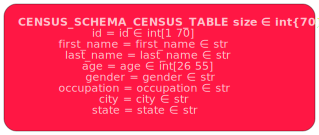

In [10]:
import graphviz
display(graphviz.Source(ds.census_schema.census_table.relation().dot()))

Any SQL query can be transformed into a `Relation`, a `qrlew` object which allows easly for query manipulation such as query translation to another dialect.

In [11]:
import pandas as pd
from pyqrlew.utils import print_query
# write a PostgreSql query: LIMIT is not allowed in MsSql but it becomes TOP
psql_query = "SELECT * FROM census_schema.census_table LIMIT 10"
relation = ds.relation(psql_query)
# we need to pass the MsSql dialect to to_query relation method
mssql_query = relation.to_query(Dialect.MsSql)
print_query(mssql_query)
# execute
results = pd.read_sql(mssql_query, engine)
results

WITH
  map_u3eo (id, first_name, last_name, age, gender, occupation, city, state) AS (SELECT "id" AS id, "first_name" AS first_name, "last_name" AS last_name, "age" AS age, "gender" AS gender, "occupation" AS occupation, "city" AS city, "state" AS state FROM "census_schema"."census_table"),
  map_1_fm (id, first_name, last_name, age, gender, occupation, city, state) AS (SELECT TOP (10) "id" AS id, "first_name" AS first_name, "last_name" AS last_name, "age" AS age, "gender" AS gender, "occupation" AS occupation, "city" AS city, "state" AS state FROM "map_u3eo")
SELECT TOP (10) * FROM "map_1_fm"


,id,first_name,last_name,age,gender,occupation,city,state
0,1,John,Doe,30,Male,Engineer,New York,NY
1,2,Jane,Doe,28,Female,Engineer,Los Angeles,CA
2,3,Bob,Smith,45,Male,Analyst,Chicago,IL
3,4,Alice,Johnson,35,Female,Data Scientist,San Francisco,CA
4,5,Tom,Brown,50,Male,Lawyer,Miami,FL
5,6,Emily,Davis,32,Female,Software Developer,Seattle,WA
6,7,Charlie,Miller,40,Male,Accountant,Boston,MA
7,8,Eva,Williams,29,Female,Marketing Manager,Austin,TX
8,9,Mike,Jones,38,Male,Analyst,Denver,CO
9,10,Sophia,Taylor,42,Female,Analyst,Atlanta,GA


There are serveral differences between PostgreSql and MsSql dialects: `LIMIT` becomes `TOP` in the `SELECT` quantifier, `LN` which is natural log in PostgreSql becomes `LOG` in MsSql, `MD5(col)` PostgreSql function is tranlated as `CONVERT(VARCHAR(MAX), HASHBYTES('MD5', col, 2))` to name a few.

In [12]:
psql_query = "SELECT age, LN(age) AS nat_log_age, MD5(CONCAT(first_name, last_name)) AS hashed_name FROM census_schema.census_table LIMIT 10"
relation = ds.relation(psql_query)

mssql_query = relation.to_query(Dialect.MsSql)
print_query(mssql_query)

results = pd.read_sql(mssql_query, engine)
results

WITH
  map_3l7g (age, nat_log_age, hashed_name) AS (SELECT "age" AS age, LOG("age") AS nat_log_age, CONVERT(VARCHAR(MAX),
  HASHBYTES('MD5', CONCAT("first_name", "last_name")),
  2) AS hashed_name FROM "census_schema"."census_table"),
  map_3_1r (age, nat_log_age, hashed_name) AS (SELECT TOP (10) "age" AS age, "nat_log_age" AS nat_log_age, "hashed_name" AS hashed_name FROM "map_3l7g")
SELECT TOP (10) * FROM "map_3_1r"


,age,nat_log_age,hashed_name
0,30,3.401197,9FD9F63E0D6487537569075DA85A0C7F
1,28,3.332205,1E218214D6994742C9D543F8FBB5EE10
2,45,3.806662,103891BACA2751A856B094DB796E3FEE
3,35,3.555348,62360D09B6561E319B76DA8AE91DD526
4,50,3.912023,5306CF440C6634E13DBF38DE4DFDA04E
5,32,3.465736,D7E90AD028AFE50F5A0AEB8A7A6818A1
6,40,3.688879,83D1145CCB93A34EBBDBD410C3F9A5CB
7,29,3.367296,5436CDEC603390DE2E6C097FA7EBD065
8,38,3.637586,FC2BA1CF41ADAA8605FA0362C2E60AF1
9,42,3.737670,0E7479482648F5E1013A27599B3F9648
